Nozzle Flow
======================

**Course : ASE 3072**

**Prof. Jin Seok Park**

In [ ]:
!pip install git+https://gitlab.com/aadl_inha/CompAir.git

  Cloning https://gitlab.com/aadl_inha/CompAir.git to /tmp/pip-req-build-kgt93h5k
  Running command git clone --filter=blob:none --quiet https://gitlab.com/aadl_inha/CompAir.git /tmp/pip-req-build-kgt93h5k
  Resolved https://gitlab.com/aadl_inha/CompAir.git to commit 50eeeb49ae08f7b9f98967184279c2c753430c2b
  Preparing metadata (setup.py) ... done


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import root

from compair import nozzle
from compair import isentropic as isen
from compair import normal_shock as nos

import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

Nozzle 유동
-----------
- $\frac{A}{A_{throat}} = 2.5$.

In [ ]:
x = np.linspace(-2, 3, 51)

# Area
A_sub = 1 - 2*np.tanh(x[:21])
A_sup = np.linspace(1, 2.5, 31)
A = [*A_sub, *A_sup[1:]]

Text(0.5, 0, 'x')

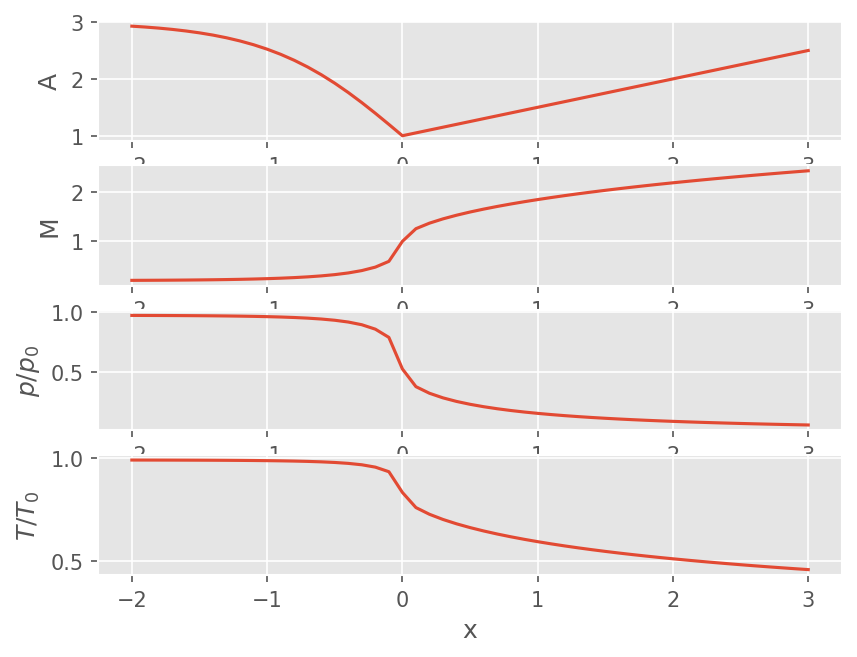

In [ ]:
# Mach number
M_sub = [nozzle.mach_by_area_ratio(A) for A in A_sub]
M_sup = [nozzle.mach_by_area_ratio(A, x0=1.1) for A in A_sup]
M = [*M_sub, *M_sup[1:]]

# Pressure and Temperature
p = [1/isen.p0_p(Mi) for Mi in M]
T = [1/isen.t0_t(Mi) for Mi in M]

# Plot
fig, axes = plt.subplots(4,1)
axes[0].plot(x, A)
axes[1].plot(x, M)
axes[2].plot(x, p)
axes[3].plot(x, T)

for i, name in enumerate(['A', 'M', r'$p/p_0$', r'$T/T_0$']):
    axes[i].set_ylabel(name)

axes[3].set_xlabel('x')

In [ ]:
# 목 대비 출구 면적비
Ae = 2.5

# 정체 압력
p0 = 1

In [ ]:
def state6(Ae, p0):
    """
    노즐 출구에서 등엔트로피 팽창된 경우

    Parameters
    ----------
    Ae : float
        목 대비 출구 면적비
    p0 : float
        전압력

    Returns
    -------
    Me6 : float
        출구 마하수
    Pe6 : float
        출구 압력
    """
    Me6 = nozzle.mach_by_area_ratio(Ae, x0=1.1)
    Pe6 = p0 / isen.p0_p(Me6)

    return Me6, Pe6

In [ ]:
def state5(Ae, p0):
    """
    노즐 출구에서 수직 충격파가 발생한 경우

    Parameters
    ----------
    Ae : float
        목 대비 출구 면적비
    p0 : float
        전압력

    Returns
    -------
    Me5 : float
        출구 마하수
    Pe5 : float
        출구 압력
    """
    # 등엔트로피 팽창된 경우
    Me6, Pe6 = state6(Ae, p0)

    # 수직충격파 계산
    Me5, _, p2_p1, p02_p01 = nos.solve(Me6)
    Pe5 = Pe6 * p2_p1

    return Me5, Pe5

In [ ]:
def state3(Ae, p0):
    """
    노즐 목에서 마하수 1, 그 이외에는 아음속

    Parameters
    ----------
    Ae : float
        목 대비 출구 면적비
    p0 : float
        전압력

    Returns
    -------
    Me3 : float
        출구 마하수
    Pe3 : float
        출구 압력
    """

    Me3 = nozzle.mach_by_area_ratio(Ae)
    Pe3 = p0 / isen.p0_p(Me3)

    return Me3, Pe3

In [ ]:
def _state2(Ae, p0, Me2):
    # 주어진 출구 마하수에서 압력 계산
    Pe2 = p0 / isen.p0_p(Me2)

    # 출구 대비 가상 Sonic 목 면적비 계산
    Ae_Ast = nozzle.area_ratio_at(Me2)
    At_Ast = max(Ae_Ast / Ae, 1)

    # 실제 노즐 목에서 마하수 및 압력
    Mt = nozzle.mach_by_area_ratio(At_Ast, x0=Me2)
    Pt = p0 / isen.p0_p(Mt)

    return Pe2, Mt, Pt


def state2(Ae, p0, pb):
    """
    노즐 내 유동이 모두 아음속인 경우

    Parameters
    ----------
    Ae : float
        목 대비 출구 면적비
    p0 : float
        전압력
    pb : float
        배압

    Returns
    -------
    Me2 : float
        출구 마하수
    Pe2 : float
        출구 압력
    Mt : float
        목 마하수
    Pt : float
        목 압력
    """
    # 수치적으로 배압에 따른 출구 마하수 계산
    f = lambda x: _state2(Ae, p0, x)[0] - pb
    Me2 = root(f, 0.1).x[0]

    # 물성치 계산
    Pe2, Mt, Pt = _state2(Ae, p0, Me2)

    return Me2, Pe2, Mt, Pt

In [ ]:
def _state4(Ae, p0, An):
    # 주어진 충격파 위치 (목 대비 면적비, An)에서 마하수, 압력 계산
    Mn1 = nozzle.mach_by_area_ratio(An, x0=1.1)
    Pn1 = p0 / isen.p0_p(Mn1)

    # 충격파 관계식 계산
    Mn2, _, p2_p1, p02_p01 = nos.solve(Mn1)
    Pn2 = Pn1 * p2_p1
    p0n = p0 * p02_p01

    # 충격파 이후 노즐에서 가상의 Sonic 목 면적 대비 출구 면적비 계산
    An_Ast = nozzle.area_ratio_at(Mn2)
    Ae_Ast = Ae / An * An_Ast

    # 출구 마하수, 압력 계산
    Me4 = nozzle.mach_by_area_ratio(Ae_Ast)
    Pe4 = p0n / isen.p0_p(Me4)

    return Me4, Pe4


def state4(Ae, p0, pb):
    """
    노즐 내 유동이 모두 아음속인 경우

    Parameters
    ----------
    Ae : float
        목 대비 출구 면적비
    p0 : float
        전압력
    pb : float
        배압

    Returns
    -------
    Me4 : float
        출구 마하수
    Pe4 : float
        출구 압력
    An : float
        충격파 발생 위치 (면적비)
    """
    # 수치적으로 배압을 만족하는 충격파 위치 (면적비) 계산
    f = lambda x: _state4(Ae, p0, x)[1] - pb
    An = root(f, 1.1).x[0]

    # 물성치 계산
    Me4, Pe4 = _state4(Ae, p0, An)

    return Me4, Pe4, An

In [ ]:
# State 6
print("""For isentropic expansion,
Mach={:.4f}, P={:.4f} @ Exit""".format(*state6(Ae, p0)))

For isentropic expansion,
Mach=2.4428, P=0.0640 @ Exit


In [ ]:
# State 5
print("""When normal shock is located at the end,
Mach={:.4f}, P={:.4f} @ Exit""".format(*state5(Ae, p0)))

When normal shock is located at the end,
Mach=0.5187, P=0.4348 @ Exit


In [ ]:
# # State 3
print("""All subsonic except at nozzle throat,
Mach={:.4f}, P={:.4f} @ Exit""".format(*state3(Ae, p0)))

All subsonic except at nozzle throat,
Mach=0.2395, P=0.9608 @ Exit


In [ ]:
pb = 0.97
print("""All subsonic with Pb = {:.4f},
Mach={:.4f}, P={:.4f} @ Exit
Mach={:.4f}, P={:.4f} @ Throat
""".format(pb, *state2(Ae, p0, pb)))

pb = 0.98
print("""All subsonic with Pb = {:.4f},
Mach={:.4f}, P={:.4f} @ Exit
Mach={:.4f}, P={:.4f} @ Throat
""".format(pb, *state2(Ae, p0, pb)))

All subsonic with Pb = 0.9700,
Mach=0.2091, P=0.9700 @ Exit
Mach=0.6490, P=0.7535 @ Throat

All subsonic with Pb = 0.9800,
Mach=0.1701, P=0.9800 @ Exit
Mach=0.4780, P=0.8552 @ Throat



In [ ]:
pb = 0.85
print("""When Pb = {:.4f},
Mach={:.4f}, P={:.4f} @ Exit
and Normal shock is located at A/A*={:.4f}
""".format(pb, *state4(Ae, p0, pb)))

pb = 0.65
print("""When Pb = {:.4f},
Mach={:.4f}, P={:.4f} @ Exit
and Normal shock is located at A/A*={:.4f}
""".format(pb, *state4(Ae, p0, pb)))

When Pb = 0.8500,
Mach=0.2704, P=0.8500 @ Exit
and Normal shock is located at A/A*=1.2522

When Pb = 0.6500,
Mach=0.3518, P=0.6500 @ Exit
and Normal shock is located at A/A*=1.7267

